In [75]:
options(repr.plot.width  = 15,
        repr.plot.height = 10)

In [76]:
library(AmesHousing)

# Helper packages
library(dplyr)     # for data manipulation
library(ggplot2)   # for awesome graphics
require(gridExtra) # for make subplot 
library(ggpubr)    # for make subplot and more
library(vip)

# Modeling process packages
library(caret)     # for resampling and model training
library(recipes)  # for feature engineering tasks

In [ ]:
knnModelInfo <- getModelInfo(model = "knn", regex = FALSE)[[1]]
knnModelInfo

# Regression

In [77]:
ames <- AmesHousing::make_ames()

In [78]:
index_2 <- createDataPartition(ames$Sale_Price, p = 0.7, 
                               list = FALSE, )
house_train <- ames[index_2, ]
house_test  <- ames[-index_2, ]

## Distance measures

$$dist(x_a, x_b) = \sqrt{ \sum_j^k(x_{aj}−x_{bj})^2}$$
$$dist(x_a, x_b) = \sum_j^k|x_{aj}−x_{bj}|$$


In [22]:
two_houses <- house_train[1:2, c("Gr_Liv_Area", "Year_Built")]
two_houses

Gr_Liv_Area,Year_Built
<int>,<int>
1656,1960
896,1961


In [23]:
# Euclidean
dist(two_houses, method = "euclidean")

         1
2 760.0007

In [24]:
# Manhattan
dist(two_houses, method = "manhattan")

    1
2 761

Debido a que la distancia de Euclides usa el cuadrado de las distancias es mas sensible a outliers. Por esto es importante normalizar la las variables antes de hacer los calculos. Esto debido a que variables con escalas mas grandes tienen mas peso sobre el resultado final que las de escala mas pequeña.

In [27]:
house1 <- data.frame(rooms = c(2,3,1), year = c(2020, 2020, 2010))
house1

rooms,year
<dbl>,<dbl>
2,2020
3,2020
1,2010


In [29]:
dist(house1)

         1        2
2  1.00000         
3 10.04988 10.19804

In [32]:
house1_sd <- house1 %>% 
    mutate(rooms=(rooms - mean(rooms))/sd(rooms),
           year=(year - mean(year))/sd(year))
house1_sd

rooms,year
<dbl>,<dbl>
0,0.5773503
1,0.5773503
-1,-1.1547005


In [34]:
dist(house1_sd)

         1        2
2 1.000000         
3 2.000000 2.645751

In [55]:
# Specify resampling strategy
cv <- trainControl(
  method = "cv", 
  number = 10,
)

# Create grid of hyperparameter values
hyper_grid <- data.frame(k = c(10, 20))

knn_fit <- train(
  Sale_Price ~ ., 
  data = train_caret, 
  method = "knn", 
  trControl = cv, 
  tuneGrid = hyper_grid,
  metric = "RMSE",
)
knn_fit

k-Nearest Neighbors 

2053 samples
  80 predictor

No pre-processing
Resampling: Cross-Validated (10 fold) 
Summary of sample sizes: 1848, 1846, 1849, 1849, 1848, 1849, ... 
Resampling results across tuning parameters:

  k   RMSE      Rsquared   MAE     
  10  45043.36  0.6895456  29281.87
  20  46591.14  0.6850019  30165.57

RMSE was used to select the optimal model using the smallest value.
The final value used for the model was k = 10.

In [57]:
class(knn_fit$finalModel)

[1] "knnreg"

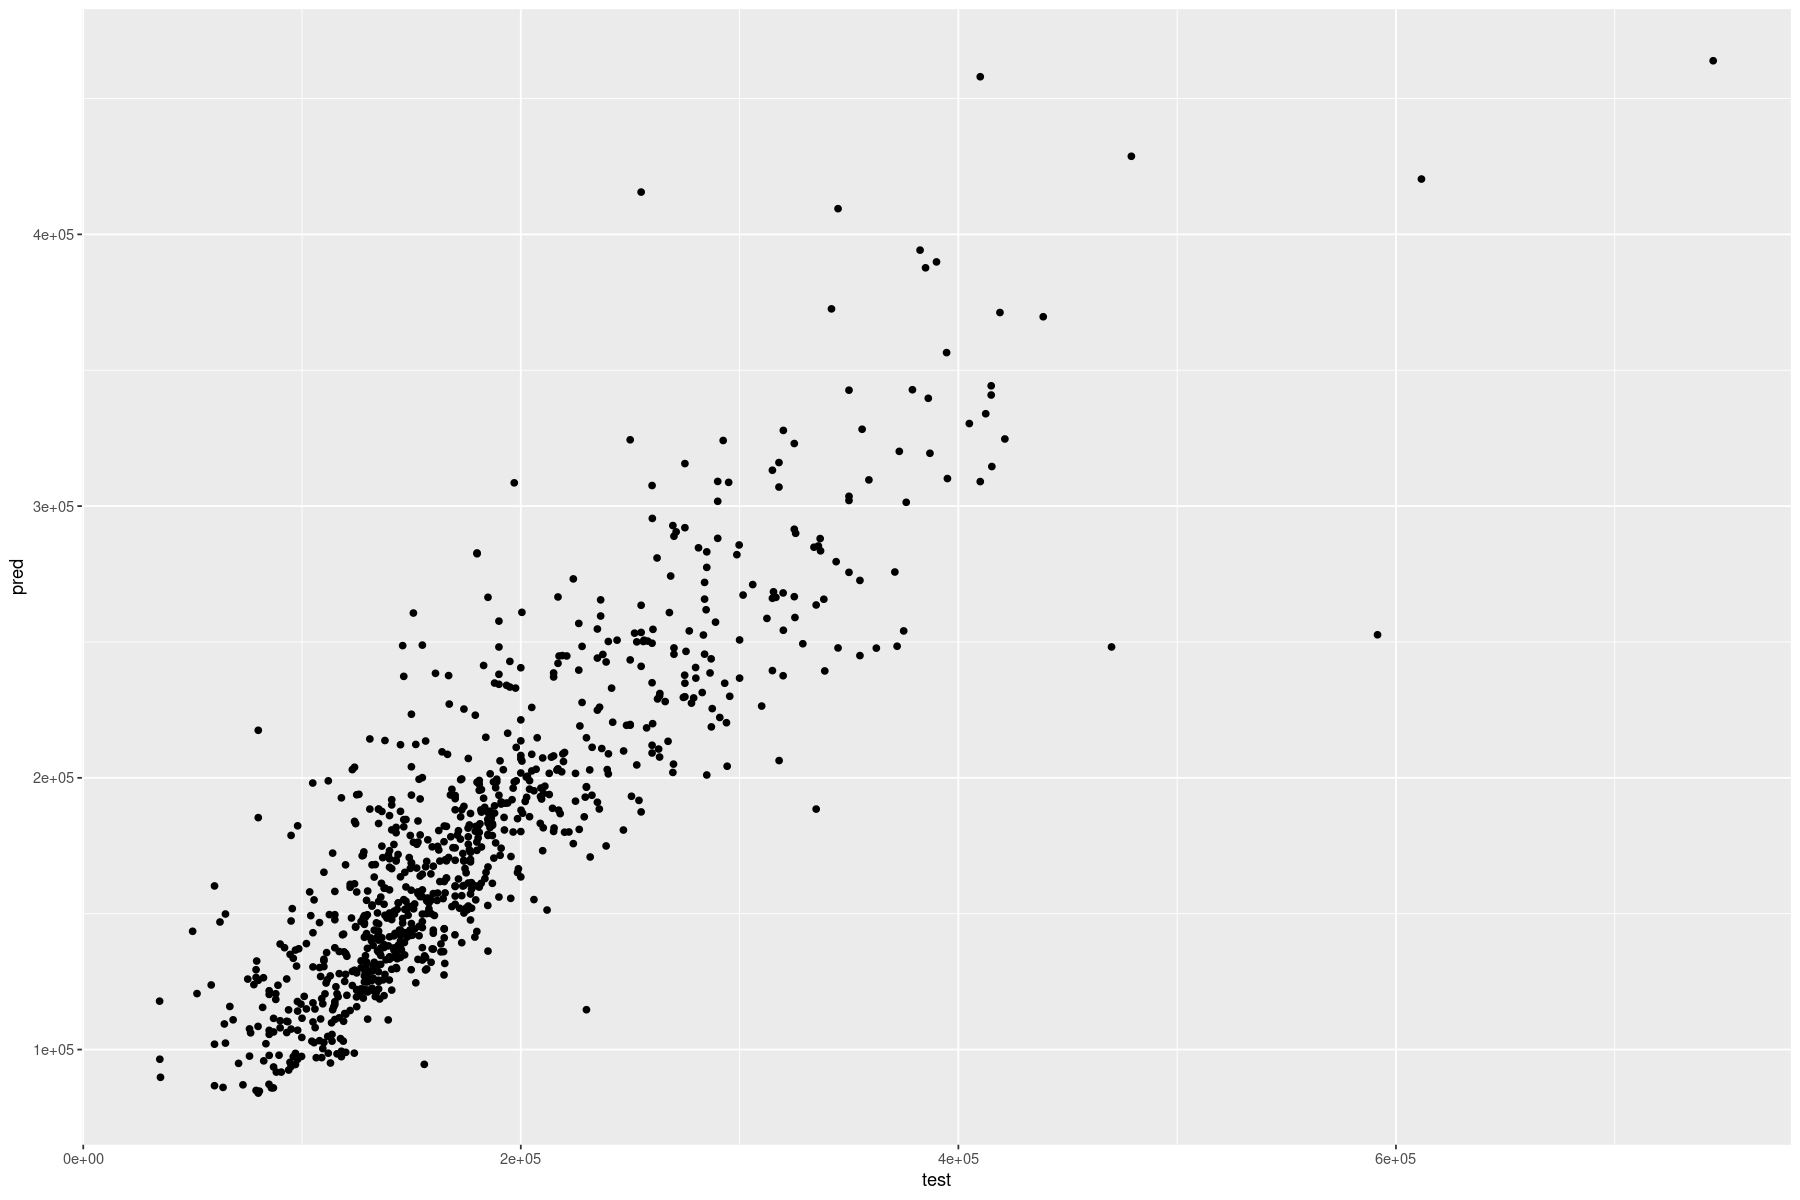

In [56]:
data.frame(pred = predict(knn_fit, test_caret), test = test_caret$Sale_Price ) %>% 
    ggplot(aes(x=test, y=pred)) + geom_point()

## Choosing k
The performance of KNNs is very sensitive to the choice of k. This was illustrated in Section 2.5.3 where low values of k typically overfit and large values often underfit. At the extremes, when k=1, we base our prediction on a single observation that has the closest distance measure. In contrast, when k=n, we are simply using the average (regression) or most common class (classification) across all training samples as our predicted value.

## Feature engineering
Hay una libreria que permite crear un pipeline con todas las transformaciones que queremos hacer a la data para que entre a nuestro modelo y que nos facilita el proceso para evaluar luego en la fase de testing donde simplemente pasamos la data son tener que procesarlar porque ya esta todo en el pipeline


<img src="https://www.clipartkey.com/mpngs/m/191-1919605_recipes-r-package-logo.png" width=200>

[Recipe doc](https://recipes.tidymodels.org/articles/Simple_Example.html)




* `step_dummy()`: creating dummy variables from categorical variables.
* `step_integer()`: creating dummy variables from categorical variables.
* `step_zzzimpute()`: where instead of “zzz” it is the name of a method, such as step_knnimpute(), step_meanimpute(), step_modeimpute(). I find that the fancier imputation methods are reeeeally slow for decently large datasets, so I would probably do this step outside of the recipes package unless you just want to do a quick mean or mode impute (which, to be honest, I often do).
* `step_scale()`: normalize to have a standard deviation of 1.
* `step_center()`: center to have a mean of 0.
* `step_nzv()`: remove variables that have (or almost have) the same value for every data point.


In each step, you need to specify which variables you want to apply it to. There are many ways to do this:

* Specifying the variable name(s) as the first argument
* Standard dplyr selectors:
    * `everything()` applies the step to all columns,
    * `contains()` allows you to specify column names that contain a specific string,
    * `starts_with()` allows you to specify column names that start with a sepcific string,
    * etc
* Functions that specify the role of the variables:
    * `all_predictors()` applies the step to the predictor variables only
    * `all_outcomes()` applies the step to the outcome variable(s) only
* Functions that specify the type of the variables:
    * `all_nominal()` applies the step to all variables that are nominal (categorical)
    * `all_numeric()` applies the step to all variables that are numeric

In [66]:
# log transformation
blueprint_house <- recipe(Sale_Price ~ ., data = house_train) %>%
  step_nzv(all_nominal()) %>%
  step_integer(matches("Qual|Cond|QC|Qu")) %>%
  step_center(all_numeric(), -all_outcomes()) %>%
  step_scale(all_numeric(), -all_outcomes()) %>%
  step_dummy(all_nominal(), -all_outcomes(), one_hot = TRUE)

In [67]:
blueprint_house

Data Recipe

Inputs:

      role #variables
   outcome          1
 predictor         80

Operations:

Sparse, unbalanced variable filter on all_nominal()
Integer encoding for matches("Qual|Cond|QC|Qu")
Centering for all_numeric(), -all_outcomes()
Scaling for all_numeric(), -all_outcomes()
Dummy variables from all_nominal(), -all_outcomes()

In [68]:
prepare <- prep(blueprint_house, training = house_train)
prepare

Data Recipe

Inputs:

      role #variables
   outcome          1
 predictor         80

Training data contained 2053 data points and no missing data.

Operations:

Sparse, unbalanced variable filter removed Street, Alley, Land_Contour, ... [trained]
Integer encoding for Condition_1, Overall_Qual, Overall_Cond, ... [trained]
Centering for Lot_Frontage, Lot_Area, ... [trained]
Scaling for Lot_Frontage, Lot_Area, ... [trained]
Dummy variables from MS_SubClass, MS_Zoning, Lot_Shape, ... [trained]

In [69]:
baked_train <- bake(prepare, new_data = house_train)
baked_test <- bake(prepare, new_data = house_test)
baked_train

Lot_Frontage,Lot_Area,Condition_1,Overall_Qual,Overall_Cond,Year_Built,Year_Remod_Add,Mas_Vnr_Area,Exter_Qual,Exter_Cond,⋯,Sale_Type_COD,Sale_Type_Con,Sale_Type_ConLD,Sale_Type_ConLI,Sale_Type_ConLw,Sale_Type_CWD,Sale_Type_New,Sale_Type_Oth,Sale_Type_VWD,Sale_Type_WD.
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
2.5476429,2.500724921,-0.04953667,-0.07846533,-0.4921892,-0.38955116,-1.1779039,0.06733218,0.6776215,0.3658399,⋯,0,0,0,0,0,0,0,0,0,1
0.6790840,0.166303123,-1.16710565,-0.78499742,0.4100111,-0.35644762,-1.1298802,-0.54970550,0.6776215,0.3658399,⋯,0,0,0,0,0,0,0,0,0,1
1.0773014,0.112774094,-0.04953667,0.62806677,-0.4921892,-0.12472280,-0.7937138,-0.54970550,-0.7477442,0.3658399,⋯,0,0,0,0,0,0,0,0,0,1
0.6178197,-0.024176798,-0.04953667,-0.07846533,0.4100111,0.86838353,0.6469992,-0.43952020,0.6776215,0.3658399,⋯,0,0,0,0,0,0,0,0,0,1
-0.4543042,-0.600366971,-0.04953667,1.33459886,-0.4921892,0.66976226,0.3588566,-0.54970550,-0.7477442,0.3658399,⋯,0,0,0,0,0,0,0,0,0,1
-0.5768327,-0.555875310,-0.04953667,1.33459886,-0.4921892,0.76907290,0.5509517,-0.54970550,-0.7477442,0.3658399,⋯,0,0,0,0,0,0,0,0,0,1
0.0664417,-0.311287043,-0.04953667,0.62806677,-0.4921892,0.90148708,0.6950230,-0.54970550,0.6776215,0.3658399,⋯,0,0,0,0,0,0,0,0,0,1
0.5259234,-0.021627796,-0.04953667,-0.07846533,-0.4921892,0.70286581,0.4549041,-0.54970550,0.6776215,0.3658399,⋯,0,0,0,0,0,0,0,0,0,1
-1.7714851,-0.255672467,-0.04953667,-0.07846533,1.3122114,0.66976226,1.0792131,-0.54970550,0.6776215,-2.2330161,⋯,0,0,0,0,0,0,0,0,0,1


In [71]:
# Specify resampling strategy
cv <- trainControl(
  method = "cv", 
  number = 10, 
)

# Create grid of hyperparameter values
hyper_grid <- expand.grid(k = seq(10, 50, by = 10))

# Tune a knn model using grid search
knn_fit <- train(
  blueprint_house, 
  data = house_train, 
  method = "knn", 
  trControl = cv, 
  tuneGrid = hyper_grid,
  metric = "RMSE"
)
knn_fit

k-Nearest Neighbors 

2053 samples
  80 predictor

Recipe steps: nzv, integer, center, scale, dummy 
Resampling: Cross-Validated (10 fold) 
Summary of sample sizes: 1848, 1849, 1848, 1847, 1848, 1847, ... 
Resampling results across tuning parameters:

  k   RMSE      Rsquared   MAE     
  10  32579.79  0.8502547  20090.03
  20  32722.68  0.8576365  20384.95
  30  33234.08  0.8579514  20700.71
  40  33948.57  0.8567274  21204.39
  50  34591.36  0.8546013  21691.14

RMSE was used to select the optimal model using the smallest value.
The final value used for the model was k = 10.

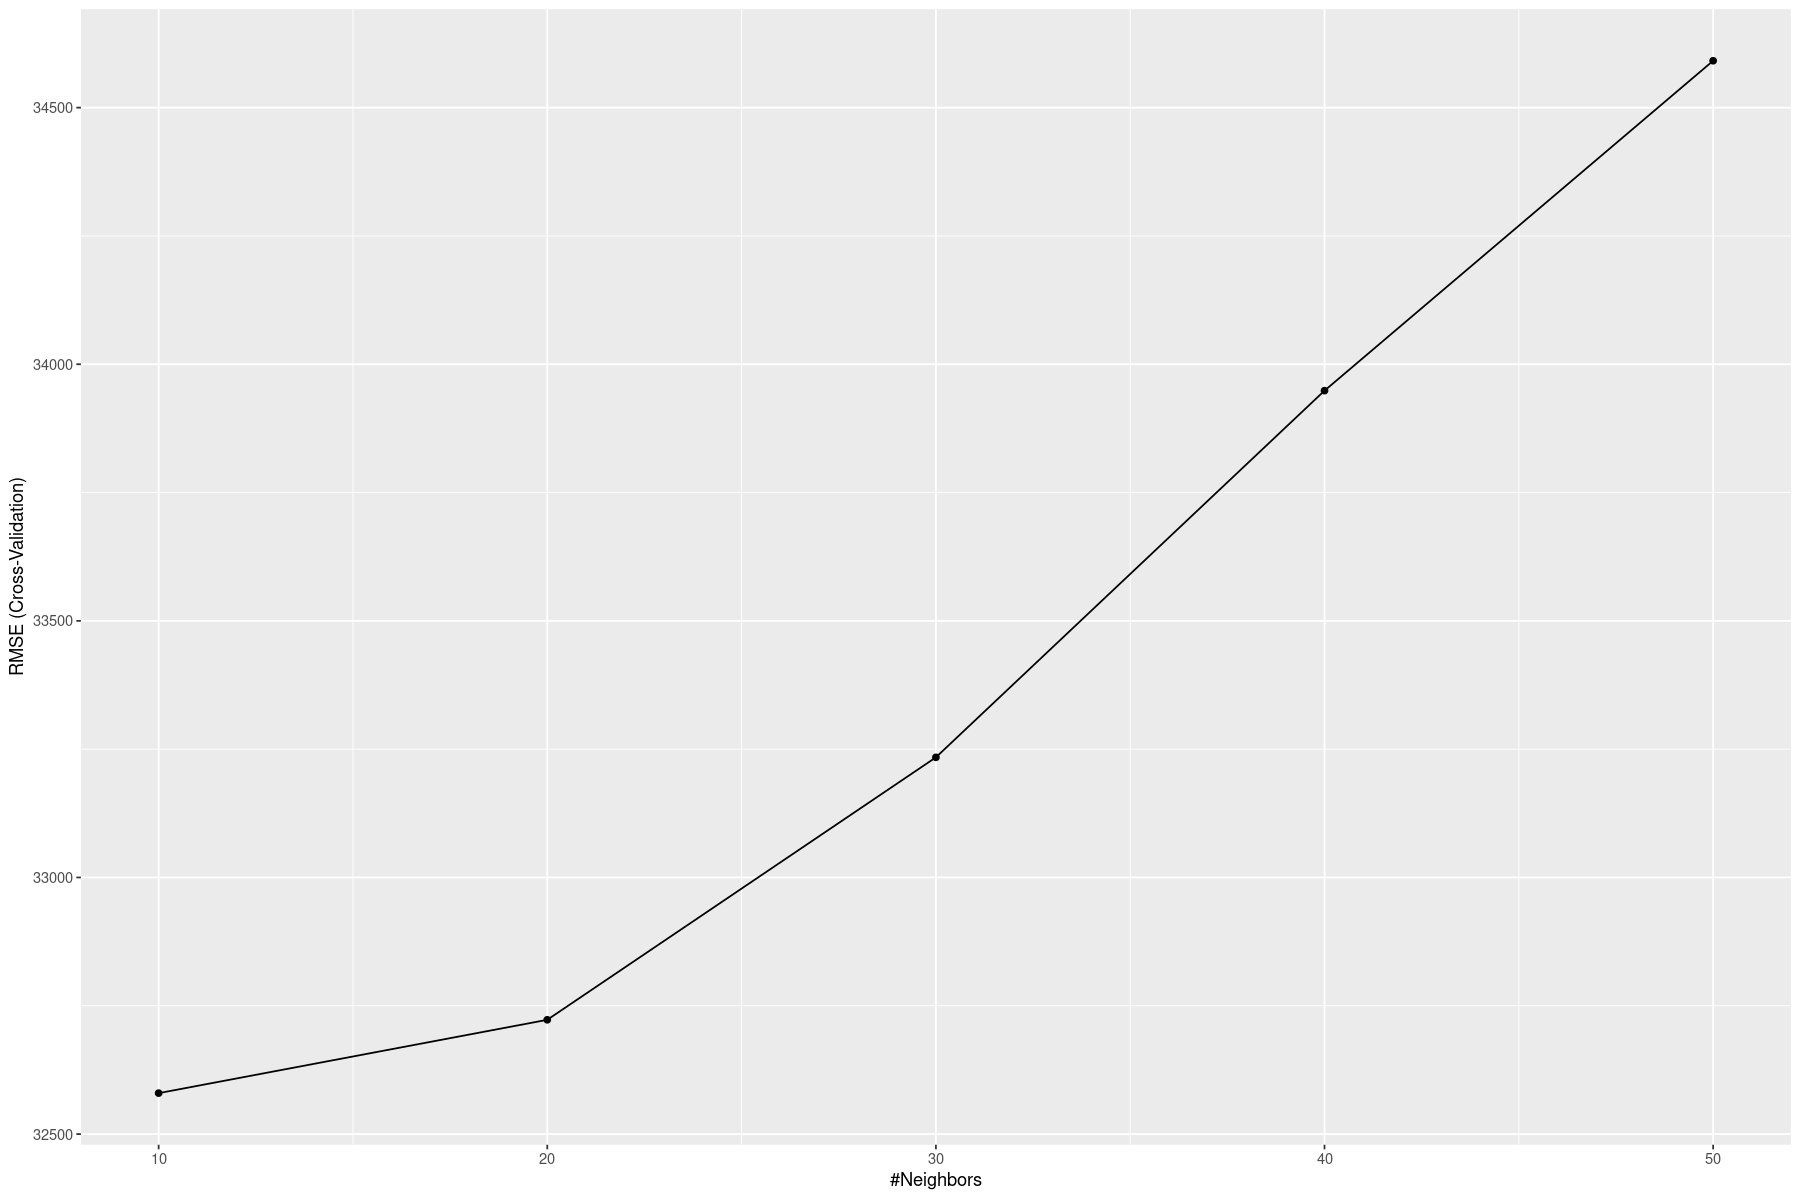

In [72]:
ggplot(knn_fit)


# Classification

In [7]:
data("attrition", package = "modeldata")
# Job attrition data
attrition <- attrition %>% 
  mutate_if(is.ordered, .funs = factor, ordered = FALSE)

In [41]:
index_caret <- createDataPartition(attrition$Attrition, p = 0.7, list = FALSE)
attrition_train <- attrition[index_caret, ]
attrition_test  <- attrition[-index_caret, ]

In [39]:
# Specify resampling strategy
cv <- trainControl(
  method = "cv", 
  number = 10,
)

# Create grid of hyperparameter values
hyper_grid <- expand.grid(k = seq(10, 20, by = 10))

knn_fit <- train(
  Sale_Price ~ ., 
  data = train_caret, 
  method = "knn", 
  trControl = cv, 
  tuneGrid = hyper_grid,
  metric = "RMSE",
)
knn_fit

[1] "Alley"              "Bedroom_AbvGr"      "Bldg_Type"         
 [4] "Bsmt_Cond"          "Bsmt_Exposure"      "Bsmt_Full_Bath"    
 [7] "Bsmt_Half_Bath"     "Bsmt_Qual"          "Bsmt_Unf_SF"       
[10] "BsmtFin_SF_1"       "BsmtFin_SF_2"       "BsmtFin_Type_1"    
[13] "BsmtFin_Type_2"     "Central_Air"        "Condition_1"       
[16] "Condition_2"        "Electrical"         "Enclosed_Porch"    
[19] "Exter_Cond"         "Exter_Qual"         "Exterior_1st"      
[22] "Exterior_2nd"       "Fence"              "Fireplace_Qu"      
[25] "Fireplaces"         "First_Flr_SF"       "Foundation"        
[28] "Full_Bath"          "Functional"         "Garage_Area"       
[31] "Garage_Cars"        "Garage_Cond"        "Garage_Finish"     
[34] "Garage_Qual"        "Garage_Type"        "Gr_Liv_Area"       
[37] "Half_Bath"          "Heating"            "Heating_QC"        
[40] "House_Style"        "Kitchen_AbvGr"      "Kitchen_Qual"      
[43] "Land_Contour"       "Land_Slope"         "Latitude"          
[46] "Longitude"          "Lot_Area"           "Lot_Config"        
[49] "Lot_Frontage"       "Lot_Shape"          "Low_Qual_Fin_SF"   
[52] "Mas_Vnr_Area"       "Mas_Vnr_Type"       "Misc_Feature"      
[55] "Misc_Val"           "Mo_Sold"            "MS_SubClass"       
[58] "MS_Zoning"          "Neighborhood"       "Open_Porch_SF"     
[61] "Overall_Cond"       "Overall_Qual"       "Paved_Drive"       
[64] "Pool_Area"          "Pool_QC"            "Roof_Matl"         
[67] "Roof_Style"         "Sale_Condition"     "Sale_Price"        
[70] "Sale_Type"          "Screen_Porch"       "Second_Flr_SF"     
[73] "Street"             "Three_season_porch" "Total_Bsmt_SF"     
[76] "TotRms_AbvGrd"      "Utilities"          "Wood_Deck_SF"      
[79] "Year_Built"         "Year_Remod_Add"     "Year_Sold"

In [42]:
glimpse(attrition_train[sort(names(attrition_train))])

Rows: 1,030
Columns: 31
$ Age                      <int> 41, 49, 37, 33, 32, 30, 36, 35, 29, 31, 34, …
$ Attrition                <fct> Yes, No, Yes, No, No, No, No, No, No, No, No…
$ BusinessTravel           <fct> Travel_Rarely, Travel_Frequently, Travel_Rar…
$ DailyRate                <int> 1102, 279, 1373, 1392, 1005, 1358, 1299, 809…
$ Department               <fct> Sales, Research_Development, Research_Develo…
$ DistanceFromHome         <int> 1, 8, 2, 3, 2, 24, 27, 16, 15, 26, 19, 5, 16…
$ Education                <fct> College, Below_College, College, Master, Col…
$ EducationField           <fct> Life_Sciences, Life_Sciences, Other, Life_Sc…
$ EnvironmentSatisfaction  <fct> Medium, High, Very_High, Very_High, Very_Hig…
$ Gender                   <fct> Female, Male, Male, Female, Male, Male, Male…
$ HourlyRate               <int> 94, 61, 92, 56, 79, 67, 94, 84, 49, 31, 93, …
$ JobInvolvement           <fct> High, Medium, Medium, High, High, High, High…
$ JobLevel                 <

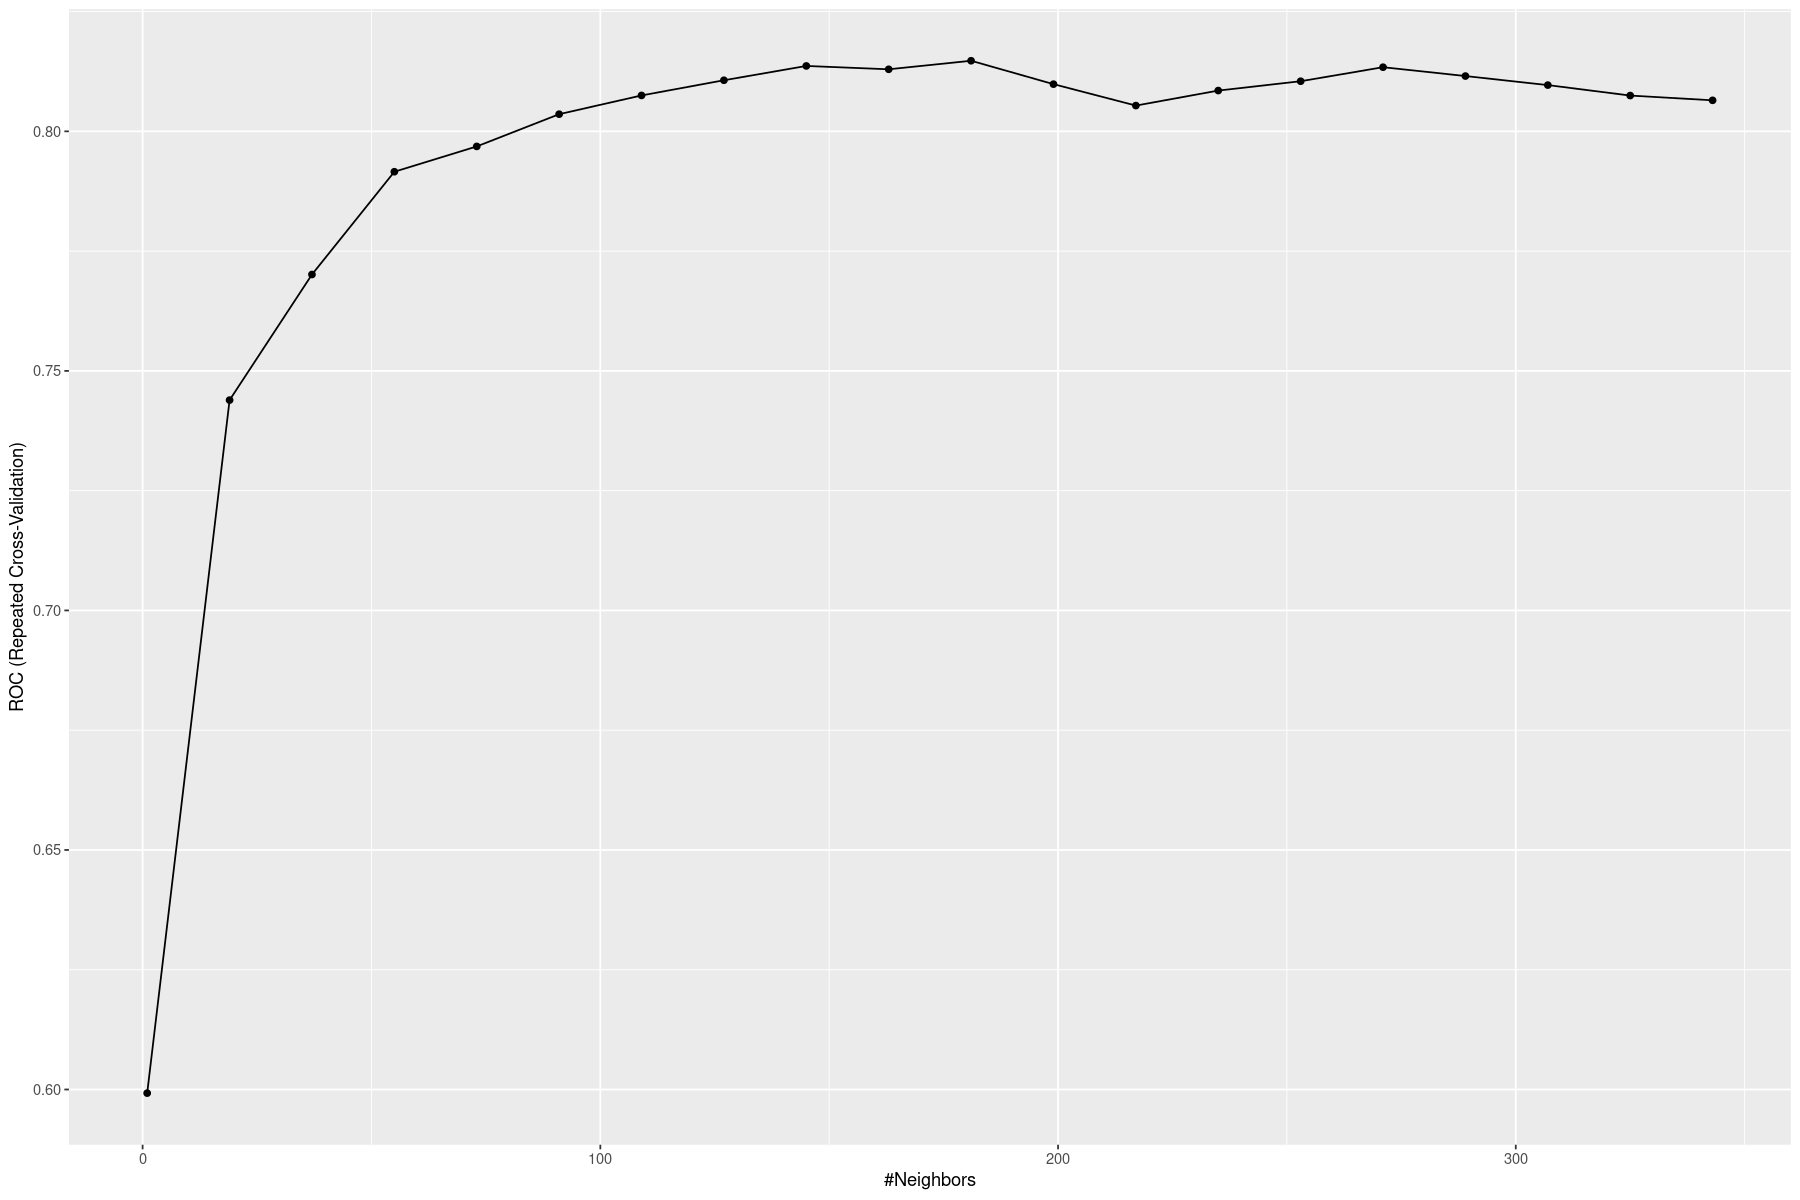

In [50]:
# Create blueprint
blueprint <- recipe(Attrition ~ ., data = attrition_train) %>%
  step_nzv(all_nominal()) %>%
  step_integer(contains("Satisfaction")) %>%
  step_integer(WorkLifeBalance) %>%
  step_integer(JobInvolvement) %>%
  step_dummy(all_nominal(), -all_outcomes(), one_hot = TRUE) %>%
  step_center(all_numeric(), -all_outcomes()) %>%
  step_scale(all_numeric(), -all_outcomes())

# Create a resampling method
cv <- trainControl(
  method = "repeatedcv", 
  number = 10, 
  repeats = 5,
  classProbs = TRUE,                 
  summaryFunction = twoClassSummary
)

# Create a hyperparameter grid search
hyper_grid <- expand.grid(
  k = floor(seq(1, nrow(attrition_train)/3, length.out = 20))
)

# Fit knn model and perform grid search
knn_grid <- train(
  blueprint, 
  data = attrition_train, 
  method = "knn", 
  trControl = cv, 
  tuneGrid = hyper_grid,
  metric = "ROC"
)

ggplot(knn_grid)